<a href="https://colab.research.google.com/github/sdm373373/nba_3x2/blob/master/3x2_play_by_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#@title Setup Notebook

!apt-get install openjdk-8-jdk-headless
!pip install pyspark
!pip install pandas
!pip install basketball_reference_scraper
!pip install pytz
!pip install findspark
!pip install oddscalculator
!mkdir games

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory 

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

findspark.init()

findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [21]:
from basketball_reference_scraper.seasons import get_schedule

games = get_schedule(2023)

games

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS
0,2022-10-18,Philadelphia 76ers,117.0,Boston Celtics,126.0
1,2022-10-18,Los Angeles Lakers,109.0,Golden State Warriors,123.0
2,2022-10-19,Orlando Magic,109.0,Detroit Pistons,113.0
3,2022-10-19,Washington Wizards,114.0,Indiana Pacers,107.0
4,2022-10-19,Houston Rockets,107.0,Atlanta Hawks,117.0
...,...,...,...,...,...
1225,2023-04-09,Utah Jazz,NaN,Los Angeles Lakers,NaN
1226,2023-04-09,New Orleans Pelicans,NaN,Minnesota Timberwolves,NaN
1227,2023-04-09,Memphis Grizzlies,NaN,Oklahoma City Thunder,NaN
1228,2023-04-09,Los Angeles Clippers,NaN,Phoenix Suns,NaN


In [22]:
import os
import time
from basketball_reference_scraper.shot_charts import get_shot_chart
from basketball_reference_scraper.constants import TEAM_TO_TEAM_ABBR

i = 0
for index, game in games.iterrows():
    gameTime = str(game["DATE"]).split(" ")[0]
    homeTeam = TEAM_TO_TEAM_ABBR[game["HOME"].upper()]
    awayTeam = TEAM_TO_TEAM_ABBR[game["VISITOR"].upper()]
    fileName = gameTime + "_" + homeTeam + ".csv"
    # if os.path.exists("games/" + fileName):
    if os.path.exists("/content/drive/MyDrive/Colab Notebooks/2022_games/" + fileName):
        print("Game: " + fileName + " already exists")
        continue
    
    try:
        print("Downloading: " + fileName)
        df = get_shot_chart(gameTime, homeTeam, awayTeam)
        df[homeTeam]['relevant_team'] = homeTeam
        df[awayTeam]['relevant_team'] = awayTeam
        dfCombined = df[homeTeam].append(df[awayTeam])
        dfCombined["period_type"] = 'QUARTER'
        dfCombined["remaining_seconds_in_period"] = dfCombined['TIME_REMAINING'].apply(lambda x: sum(float(x) * 60 ** i for i, x in enumerate(reversed(str(x).split(':')))))
        dfCombined["home_team"] = homeTeam
        dfCombined["away_team"] = awayTeam
        dfCombined.rename(columns={'QUARTER': 'period', 'VALUE': 'shot_type', 'MAKE_MISS': 'shot_result', 'PLAYER': 'player'}, inplace=True)
        dfCombined.drop(columns=['TIME_REMAINING', 'x', 'y', 'DISTANCE'], inplace=True)
        dfCombined = dfCombined[['period','period_type','remaining_seconds_in_period','relevant_team','away_team','home_team','player','shot_type','shot_result']]
        # dfCombined.to_csv("games/" + fileName, index=False)
        dfCombined.to_csv("/content/drive/MyDrive/Colab Notebooks/2022_games/" + fileName, index=False)
        i += 1

        time.sleep(7)
    except:
        print("Error: " + fileName)
        break

print("Downloaded " + str(i) + " games")

Game: 2022-10-18_BOS.csv already exists
Game: 2022-10-18_GSW.csv already exists
Game: 2022-10-19_DET.csv already exists
Game: 2022-10-19_IND.csv already exists
Game: 2022-10-19_ATL.csv already exists
Game: 2022-10-19_BRK.csv already exists
Game: 2022-10-19_MEM.csv already exists
Game: 2022-10-19_MIA.csv already exists
Game: 2022-10-19_TOR.csv already exists
Game: 2022-10-19_MIN.csv already exists
Game: 2022-10-19_SAS.csv already exists
Game: 2022-10-19_UTA.csv already exists
Game: 2022-10-19_PHO.csv already exists
Game: 2022-10-19_SAC.csv already exists
Game: 2022-10-20_PHI.csv already exists
Game: 2022-10-20_LAL.csv already exists
Game: 2022-10-21_CHO.csv already exists
Game: 2022-10-21_IND.csv already exists
Game: 2022-10-21_WAS.csv already exists
Game: 2022-10-21_ATL.csv already exists
Game: 2022-10-21_BRK.csv already exists
Game: 2022-10-21_MIA.csv already exists
Game: 2022-10-21_NYK.csv already exists
Game: 2022-10-21_HOU.csv already exists
Game: 2022-10-21_MIN.csv already exists


In [30]:
import os
import glob
import pandas as pd

# all_filenames = [i for i in glob.glob('games/[0-9AZ]*.{}'.format('csv'))]
all_filenames = [i for i in glob.glob('/content/drive/MyDrive/Colab Notebooks/2022_games/[0-9AZ]*.{}'.format('csv'))]

combined_csv = pd.DataFrame()

#combine all files in the list
for f in all_filenames:
    df = pd.read_csv(f)
    df.insert(0, 'game_id', f.split('/')[-1].split('.')[0])
    combined_csv = pd.concat([combined_csv, df])

#export to csv
combined_csv.to_csv("combined_games.csv", index=False, encoding='utf-8')

In [31]:
#import findspark
#findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("NBA_Data").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

dfAll = spark.read.format("csv").option("header", "true").load("combined_games.csv")

dfAll.createOrReplaceTempView("all_shots")

dfAll.show(10)

+--------------+------+-----------+---------------------------+-------------+---------+---------+-----------------+---------+-----------+
|       game_id|period|period_type|remaining_seconds_in_period|relevant_team|away_team|home_team|           player|shot_type|shot_result|
+--------------+------+-----------+---------------------------+-------------+---------+---------+-----------------+---------+-----------+
|2022-10-21_NYK|   1.0|    QUARTER|                      699.0|          NYK|      DET|      NYK|    Evan Fournier|      3.0|       MAKE|
|2022-10-21_NYK|   1.0|    QUARTER|                      662.0|          NYK|      DET|      NYK|    Jalen Brunson|      2.0|       MISS|
|2022-10-21_NYK|   1.0|    QUARTER|                      633.0|          NYK|      DET|      NYK|Mitchell Robinson|      2.0|       MAKE|
|2022-10-21_NYK|   1.0|    QUARTER|                      601.0|          NYK|      DET|      NYK|       RJ Barrett|      2.0|       MAKE|
|2022-10-21_NYK|   1.0|    QUARTER

In [32]:
# Shot breakdown for first 3 mins by player
df3x2_player_detail = spark.sql("""select game_id, relevant_team, player, shot_type, shot_result, count(*) as total_shots
from all_shots 
where period_type = 'QUARTER' and period = 1 and cast(remaining_seconds_in_period as int) > 540 --and game_id > '2022-02-15'
group by game_id, relevant_team, player, shot_type, shot_result
order by game_id, relevant_team, player, shot_type""")

df3x2_player_detail.createOrReplaceTempView("3x2_player_detail")

df3x2_player_shot_breakdown = spark.sql("""select d.relevant_team, d.player,
  coalesce((select sum(total_shots) from 3x2_player_detail x where d.player = x.player and d.relevant_team = x.relevant_team and x.shot_type = 3 and x.shot_result = 'MAKE'), 0) as three_pt_made,
  coalesce((select sum(total_shots) from 3x2_player_detail x where d.player = x.player and d.relevant_team = x.relevant_team and x.shot_type = 3), 0) as three_pt_attempts,
  coalesce((select sum(total_shots) from 3x2_player_detail x where d.player = x.player and d.relevant_team = x.relevant_team), 0) as total_shots
from (select distinct relevant_team, player from 3x2_player_detail) d""")

df3x2_player_shot_breakdown.createOrReplaceTempView("3x2_player_shot_breakdown")

df3x2_player_shot_breakdown_pt2 = spark.sql("""select relevant_team, player, three_pt_made, three_pt_attempts, total_shots,
  ROUND((three_pt_made / three_pt_attempts * 100), 2) as 3pt_make_percentage,
  ROUND((three_pt_attempts / total_shots * 100), 2) as 3pt_shot_percentage
from 3x2_player_shot_breakdown
order by three_pt_made desc""")

df3x2_player_shot_breakdown_pt2.createOrReplaceTempView("3x2_player_shot_breakdown_pt2")

df3x2_player_shot_breakdown_pt2.show()

+-------------+------------------+-------------+-----------------+-----------+-------------------+-------------------+
|relevant_team|            player|three_pt_made|three_pt_attempts|total_shots|3pt_make_percentage|3pt_shot_percentage|
+-------------+------------------+-------------+-----------------+-----------+-------------------+-------------------+
|          WAS|Kristaps Porziņģis|            7|               13|         21|              53.85|               61.9|
|          SAS|    Keldon Johnson|            6|               10|         19|               60.0|              52.63|
|          DEN|Michael Porter Jr.|            6|                8|         13|               75.0|              61.54|
|          GSW|    Andrew Wiggins|            6|               10|         16|               60.0|               62.5|
|          SAC|      De'Aaron Fox|            5|                9|         11|              55.56|              81.82|
|          MIA|       Tyler Herro|            5|

In [33]:
# Shot breakdown for first 3 minutes
df3x2_detail = spark.sql("""select game_id, home_team, away_team, relevant_team, shot_type, shot_result, count(*) as total_shots
from all_shots 
where period_type = 'QUARTER' and period = 1 and cast(remaining_seconds_in_period as int) > 540
group by game_id, home_team, away_team, relevant_team, shot_type, shot_result
order by game_id, shot_type""")

df3x2_detail.createOrReplaceTempView("3x2_detail")

df3x2_detail.show()

+--------------+---------+---------+-------------+---------+-----------+-----------+
|       game_id|home_team|away_team|relevant_team|shot_type|shot_result|total_shots|
+--------------+---------+---------+-------------+---------+-----------+-----------+
|2022-10-18_BOS|      BOS|      PHI|          PHI|      2.0|       MISS|          4|
|2022-10-18_BOS|      BOS|      PHI|          BOS|      2.0|       MISS|          3|
|2022-10-18_BOS|      BOS|      PHI|          PHI|      2.0|       MAKE|          1|
|2022-10-18_BOS|      BOS|      PHI|          BOS|      2.0|       MAKE|          2|
|2022-10-18_BOS|      BOS|      PHI|          BOS|      3.0|       MAKE|          1|
|2022-10-18_BOS|      BOS|      PHI|          PHI|      3.0|       MISS|          1|
|2022-10-18_BOS|      BOS|      PHI|          BOS|      3.0|       MISS|          1|
|2022-10-18_GSW|      GSW|      LAL|          GSW|      2.0|       MISS|          4|
|2022-10-18_GSW|      GSW|      LAL|          LAL|      2.0|     

In [34]:
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

df3x2_makes = spark.sql("""select game_id, home_team, away_team, sum(total_shots) as 3pt_makes
from 3x2_detail 
where shot_result = 'MAKE' and shot_type = 3
group by game_id, home_team, away_team, shot_type, shot_result
order by game_id""")

df3x2_makes.createOrReplaceTempView("3x2_makes")

df3x2_zeros = spark.sql("""select distinct game_id, home_team, away_team, 0 as 3pt_makes
from all_shots where game_id not in (select distinct game_id from 3x2_makes)""")

df3x2_results = df3x2_makes.union(df3x2_zeros).withColumn("game_number", row_number().over(Window.partitionBy(lit(0)).orderBy(col("game_id"))))

df3x2_results.createOrReplaceTempView("3x2_results")

df3x2_results.show()

+--------------+---------+---------+---------+-----------+
|       game_id|home_team|away_team|3pt_makes|game_number|
+--------------+---------+---------+---------+-----------+
|2022-10-18_BOS|      BOS|      PHI|        1|          1|
|2022-10-18_GSW|      GSW|      LAL|        0|          2|
|2022-10-19_ATL|      ATL|      HOU|        0|          3|
|2022-10-19_BRK|      BRK|      NOP|        1|          4|
|2022-10-19_DET|      DET|      ORL|        0|          5|
|2022-10-19_IND|      IND|      WAS|        3|          6|
|2022-10-19_MEM|      MEM|      NYK|        3|          7|
|2022-10-19_MIA|      MIA|      CHI|        2|          8|
|2022-10-19_MIN|      MIN|      OKC|        0|          9|
|2022-10-19_PHO|      PHO|      DAL|        0|         10|
|2022-10-19_SAC|      SAC|      POR|        4|         11|
|2022-10-19_SAS|      SAS|      CHO|        0|         12|
|2022-10-19_TOR|      TOR|      CLE|        1|         13|
|2022-10-19_UTA|      UTA|      DEN|        1|         1

+---------+-----+
|3pt_makes|count|
+---------+-----+
|        0|   31|
|        1|   60|
|        2|   34|
|        3|   21|
|        4|    7|
|        5|    3|
|        6|    2|
+---------+-----+

67 / 158 = 42.41%


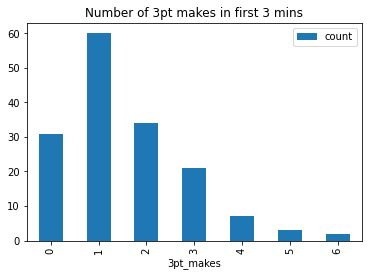

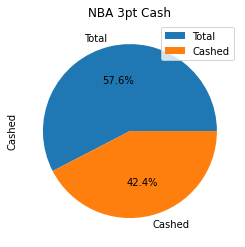

In [35]:
import pandas
from builtins import round

df3x2Breakdown = spark.sql("""select 3pt_makes, count(3pt_makes) as count
from 3x2_results 
group by 3pt_makes
order by 3pt_makes""")

df3x2Breakdown.show()

df3x2Breakdown.toPandas().plot(kind='bar', x='3pt_makes', y='count', title='Number of 3pt makes in first 3 mins')



total_games = spark.sql("""select count(distinct game_id) as total_games from all_shots""").first().total_games

cashed = spark.sql("""select count(3pt_makes) as cash from 3x2_results
where 3pt_makes >= 2""").first().cash

dfTotals = pandas.DataFrame({"Cashed": [total_games - cashed, cashed]}, index=["Total", "Cashed"])

dfTotals.plot(kind='pie', y='Cashed', autopct='%1.1f%%', title='NBA 3pt Cash')

print("{} / {} = {}%".format(cashed, total_games, round((cashed / total_games) * 100, 2)))

In [36]:
import pandas

df3x2TeamBreakdown = spark.sql("""select game_number, home_team, away_team, 3pt_makes, count(3pt_makes) as count
from 3x2_results 
group by game_number, home_team, away_team, 3pt_makes
order by home_team, 3pt_makes""")

df3x2TeamBreakdown.createOrReplaceTempView("3x2_team_breakdown")

df3x2TeamBreakdown.show()

df3x2TeamBreakdownMakes = spark.sql("""select game_number, home_team, away_team, 3pt_makes, sum(count) as count
from 3x2_team_breakdown 
where 3pt_makes >= 2
group by game_number, home_team, away_team, 3pt_makes""")

df3x2TeamBreakdownMakes.createOrReplaceTempView("3x2_team_breakdown_makes")

df3x2TeamBreakdownMakes.show()

df3x2TeamBreakdownMisses = spark.sql("""select game_number, home_team, away_team, 3pt_makes, sum(count) as count
from 3x2_team_breakdown 
where 3pt_makes < 2
group by game_number, home_team, away_team, 3pt_makes""")

df3x2TeamBreakdownMisses.createOrReplaceTempView("3x2_team_breakdown_misses")

df3x2TeamBreakdownMisses.show()

+-----------+---------+---------+---------+-----+
|game_number|home_team|away_team|3pt_makes|count|
+-----------+---------+---------+---------+-----+
|          3|      ATL|      HOU|        0|    1|
|        132|      ATL|      NOP|        1|    1|
|         17|      ATL|      ORL|        1|    1|
|         37|      ATL|      CHO|        1|    1|
|        144|      ATL|      MIL|        2|    1|
|        120|      BOS|      CHI|        1|    1|
|          1|      BOS|      PHI|        1|    1|
|         70|      BOS|      CLE|        1|    1|
|         88|      BOS|      WAS|        4|    1|
|         18|      BRK|      TOR|        0|    1|
|        103|      BRK|      CHI|        0|    1|
|          4|      BRK|      NOP|        1|    1|
|         66|      BRK|      DAL|        1|    1|
|         96|      BRK|      IND|        1|    1|
|         81|      BRK|      IND|        1|    1|
|        107|      CHI|      CHO|        0|    1|
|        145|      CHI|      TOR|        0|    1|


In [37]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

df3x2TeamMakes = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes
    group by away_team""")
)

df3x2TeamMakes.createOrReplaceTempView("3x2_team_makes")

df3x2TeamMakesFinal = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMisses = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses
    group by away_team""")
)

df3x2TeamMisses.createOrReplaceTempView("3x2_team_misses")

df3x2TeamMissesFinal = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGames = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes
    union all
    select team, count
    from 3x2_team_misses
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdown = dfTeamTotalGames.join(df3x2TeamMakesFinal, on='team', how="outer").join(df3x2TeamMissesFinal, on='team', how="outer").withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .selectExpr('rank', 'team', "coalesce(make_count, 0) as make_count", 'coalesce(miss_count, 0) as miss_count', 'total_games', 'coalesce(make_pct, 0) as make_pct')
dfFullTeamBreakdown.createOrReplaceTempView("full_team_breakdown")

dfFullTeamBreakdown.show()

+----+----+----------+----------+-----------+--------+
|rank|team|make_count|miss_count|total_games|make_pct|
+----+----+----------+----------+-----------+--------+
|   1| GSW|         8|         3|         11|   72.73|
|   2| SAC|         6|         3|          9|   66.67|
|   3| UTA|         8|         4|         12|   66.67|
|   4| MIA|         7|         4|         11|   63.64|
|   5| WAS|         7|         4|         11|   63.64|
|   6| DEN|         6|         4|         10|    60.0|
|   7| IND|         6|         4|         10|    60.0|
|   8| NYK|         6|         4|         10|    60.0|
|   9| LAL|         5|         5|         10|    50.0|
|  10| MIL|         5|         5|         10|    50.0|
|  11| POR|         5|         5|         10|    50.0|
|  12| DET|         5|         6|         11|   45.45|
|  13| MIN|         5|         6|         11|   45.45|
|  14| ORL|         5|         6|         11|   45.45|
|  15| PHI|         5|         6|         11|   45.45|
|  16| BOS

In [38]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

game_number_last_15 = spark.sql("""select max(game_number) as max_game_number
from 3x2_team_breakdown""").first().max_game_number - 85*3

df3x2TeamBreakdownMakesLast15 = df3x2TeamBreakdownMakes.filter(col("game_number") >= game_number_last_15)
df3x2TeamBreakdownMissesLast15 = df3x2TeamBreakdownMisses.filter(col("game_number") >= game_number_last_15)
df3x2TeamBreakdownMakesLast15.createOrReplaceTempView("3x2_team_breakdown_makes_last_15")
df3x2TeamBreakdownMissesLast15.createOrReplaceTempView("3x2_team_breakdown_misses_last_15")

df3x2TeamMakesLast15 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes_last_15
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes_last_15
    group by away_team""")
)

df3x2TeamMakesLast15.createOrReplaceTempView("3x2_team_makes_last_15")

df3x2TeamMakesFinalLast15 = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes_last_15
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMissesLast15 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses_last_15
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses_last_15
    group by away_team""")
)

df3x2TeamMissesLast15.createOrReplaceTempView("3x2_team_misses_last_15")

df3x2TeamMissesFinalLast15 = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses_last_15
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGamesLast15 = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes_last_15
    union all
    select team, count
    from 3x2_team_misses_last_15
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdownLast15 = dfTeamTotalGamesLast15.join(df3x2TeamMakesFinalLast15, on='team', how='outer').join(df3x2TeamMissesFinalLast15, on='team', how='outer').withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .selectExpr('rank', 'team', "coalesce(make_count, 0) as make_count", 'coalesce(miss_count, 0) as miss_count', 'total_games', 'coalesce(make_pct, 0) as make_pct')
dfFullTeamBreakdownLast15.createOrReplaceTempView("full_team_breakdown_last_15")

dfFullTeamBreakdownLast15.show()

+----+----+----------+----------+-----------+--------+
|rank|team|make_count|miss_count|total_games|make_pct|
+----+----+----------+----------+-----------+--------+
|   1| GSW|         8|         3|         11|   72.73|
|   2| SAC|         6|         3|          9|   66.67|
|   3| UTA|         8|         4|         12|   66.67|
|   4| MIA|         7|         4|         11|   63.64|
|   5| WAS|         7|         4|         11|   63.64|
|   6| DEN|         6|         4|         10|    60.0|
|   7| IND|         6|         4|         10|    60.0|
|   8| NYK|         6|         4|         10|    60.0|
|   9| LAL|         5|         5|         10|    50.0|
|  10| MIL|         5|         5|         10|    50.0|
|  11| POR|         5|         5|         10|    50.0|
|  12| DET|         5|         6|         11|   45.45|
|  13| MIN|         5|         6|         11|   45.45|
|  14| ORL|         5|         6|         11|   45.45|
|  15| PHI|         5|         6|         11|   45.45|
|  16| BOS

In [39]:
import pandas
from pyspark.sql.functions import col, round, row_number, lit
from pyspark.sql.window import Window

game_number_last_5 = spark.sql("""select max(game_number) as max_game_number
from 3x2_team_breakdown""").first().max_game_number - 85

df3x2TeamBreakdownMakesLast5 = df3x2TeamBreakdownMakes.filter(col("game_number") >= game_number_last_5)
df3x2TeamBreakdownMissesLast5 = df3x2TeamBreakdownMisses.filter(col("game_number") >= game_number_last_5)
df3x2TeamBreakdownMakesLast5.createOrReplaceTempView("3x2_team_breakdown_makes_last_5")
df3x2TeamBreakdownMissesLast5.createOrReplaceTempView("3x2_team_breakdown_misses_last_5")

df3x2TeamMakesLast5 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_makes_last_5
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_makes_last_5
    group by away_team""")
)

df3x2TeamMakesLast5.createOrReplaceTempView("3x2_team_makes_last_5")

df3x2TeamMakesFinalLast5 = spark.sql("""select team, sum(count) as make_count
from 3x2_team_makes_last_5
group by team
order by make_count desc""")

# df3x2TeamMakesFinal.show()

df3x2TeamMissesLast5 = spark.sql("""select home_team as team, sum(count) as count
from 3x2_team_breakdown_misses_last_5
group by home_team""").union(
    spark.sql("""select away_team as team, sum(count) as count
    from 3x2_team_breakdown_misses_last_5
    group by away_team""")
)

df3x2TeamMissesLast5.createOrReplaceTempView("3x2_team_misses_last_5")

df3x2TeamMissesFinalLast5 = spark.sql("""select team, sum(count) as miss_count
from 3x2_team_misses_last_5
group by team
order by miss_count desc""")

# df3x2TeamMissesFinal.show()

dfTeamTotalGamesLast5 = spark.sql("""select team, sum(count) as total_games
from (
    select team, count
    from 3x2_team_makes_last_5
    union all
    select team, count
    from 3x2_team_misses_last_5
) a
group by team
order by total_games desc""")

# dfTeamTotalGames.show()

dfFullTeamBreakdownLast5 = dfTeamTotalGamesLast5.join(df3x2TeamMakesFinalLast5, on='team', how="outer").join(df3x2TeamMissesFinalLast5, on='team', how="outer").withColumn("make_pct", round((col("make_count") / col("total_games")) * 100, 2)) \
    .select('team', 'make_count', 'miss_count', 'total_games', 'make_pct').orderBy('make_pct', ascending=False).withColumn("rank", row_number().over(Window.partitionBy(lit(0)).orderBy(col("make_pct").desc()))) \
        .selectExpr('rank', 'team', "coalesce(make_count, 0) as make_count", 'coalesce(miss_count, 0) as miss_count', 'total_games', 'coalesce(make_pct, 0) as make_pct')
dfFullTeamBreakdownLast5.createOrReplaceTempView("full_team_breakdown_last_5")

dfFullTeamBreakdownLast5.show()

+----+----+----------+----------+-----------+--------+
|rank|team|make_count|miss_count|total_games|make_pct|
+----+----+----------+----------+-----------+--------+
|   1| UTA|         5|         1|          6|   83.33|
|   2| BOS|         4|         1|          5|    80.0|
|   3| MIA|         4|         1|          5|    80.0|
|   4| DEN|         3|         1|          4|    75.0|
|   5| GSW|         4|         2|          6|   66.67|
|   6| LAL|         4|         2|          6|   66.67|
|   7| ORL|         4|         2|          6|   66.67|
|   8| OKC|         3|         2|          5|    60.0|
|   9| POR|         3|         2|          5|    60.0|
|  10| SAC|         3|         2|          5|    60.0|
|  11| MIL|         4|         3|          7|   57.14|
|  12| WAS|         4|         3|          7|   57.14|
|  13| HOU|         3|         3|          6|    50.0|
|  14| MIN|         3|         3|          6|    50.0|
|  15| NYK|         3|         3|          6|    50.0|
|  16| CLE

In [40]:
import pandas

dfFullTeamBreakdownWithRecent = spark.sql("""select ftb.*, concat(ftb5.make_count, '-', ftb5.miss_count) as make_miss_recent_5, concat(ftb15.make_count, '-', ftb15.miss_count) as make_miss_recent_15,
case when (ftb5.make_count / (ftb5.make_count + ftb5.miss_count)) * 100 > ftb.make_pct then 'up' else 'down' end as trend_recent_5
from full_team_breakdown ftb
inner join full_team_breakdown_last_15 ftb15 on ftb.team = ftb15.team
inner join full_team_breakdown_last_5 ftb5 on ftb.team = ftb5.team
order by ftb.rank
""")

dfFullTeamBreakdownWithRecent.cache()

dfFullTeamBreakdownWithRecent.createOrReplaceTempView("full_team_breakdown_with_recent")

dfFullTeamBreakdownWithRecent.show()

+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+
|rank|team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|
+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+
|   1| GSW|         8|         3|         11|   72.73|               4-2|                8-3|          down|
|   2| UTA|         8|         4|         12|   66.67|               5-1|                8-4|            up|
|   3| SAC|         6|         3|          9|   66.67|               3-2|                6-3|          down|
|   4| MIA|         7|         4|         11|   63.64|               4-1|                7-4|            up|
|   5| WAS|         7|         4|         11|   63.64|               4-3|                7-4|          down|
|   6| NYK|         6|         4|         10|    60.0|               3-3|                6-4|          down|
|   7| DEN|        

In [41]:
from pyspark.sql.functions import col, round, row_number, lit, dense_rank
from pyspark.sql.window import Window

# Get Shot breakdown per team in last 5 games
df3x2_total_shots_with_game_number = spark.sql("""SELECT game_id, relevant_team as offense_team, 
case when relevant_team != home_team then home_team else away_team end as defense_team, sum(total_shots) as total_shots
from 3x2_detail
group by game_id, relevant_team, case when relevant_team != home_team then home_team else away_team end
""").withColumn("game_number", dense_rank().over(Window.partitionBy(lit(0)).orderBy(col("game_id"))))

# df3x2_total_shots_with_game_number.show()

df3x2_total_shots_last_5 = df3x2_total_shots_with_game_number.filter(col("game_number") >= game_number_last_5)
df3x2_total_shots_last_5.createOrReplaceTempView("3x2_total_shots_last_5")

df3x2_all_shots_last_5 = spark.sql("""SELECT *, 
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 3 and shot_result = 'MAKE'), 0) as offense_3_makes,
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 3), 0) as offense_3_shots,
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 2 and shot_result = 'MAKE'), 0) as offense_2_makes,
    coalesce((select sum(total_shots) from 3x2_detail x where a.game_id = x.game_id and a.offense_team = x.relevant_team and shot_type = 2), 0) as offense_2_shots
from 3x2_total_shots_last_5 a
""")
df3x2_all_shots_last_5.createOrReplaceTempView("3x2_all_shots_last_5")

# df3x2_all_shots_last_5.show()

df3x2_all_stats_last_5 = spark.sql("""SELECT *, 
    round(offense_3_makes / 3, 2) as offense_3_makes_per_min,
    round(offense_3_shots / 3, 2) as offense_3_shots_per_min,
    round(offense_3_shots / (offense_3_shots + offense_2_shots) * 100) as offense_3_atmpt_pct
from 3x2_all_shots_last_5 a
""")
df3x2_all_stats_last_5.createOrReplaceTempView("3x2_all_stats_last_5")
# df3x2_all_stats_last_5.show()

df3x2_rollup_last_5_pt1 = spark.sql("""SELECT offense_team as team, round(avg(offense_3_makes), 1) as offense_3_makes, round(avg(offense_3_shots), 1) as offense_3_shots, round(avg(total_shots), 1) as total_shots
from 3x2_all_stats_last_5
group by offense_team
""")
df3x2_rollup_last_5_pt1.createOrReplaceTempView("3x2_rollup_last_5_pt1")

df3x2_rollup_last_5_pt2 = spark.sql("""select *, 
    coalesce((select round(avg(offense_3_makes), 1) from 3x2_all_stats_last_5 x where x.defense_team = a.team group by x.defense_team), 0) as defense_3_makes,
    coalesce((select round(avg(offense_3_shots), 1) from 3x2_all_stats_last_5 x where x.defense_team = a.team group by x.defense_team), 0) as defense_3_shots,
    coalesce((select round(avg(total_shots), 1) from 3x2_all_stats_last_5 x where x.defense_team = a.team group by x.defense_team), 0) as defense_total_shots
    from 3x2_rollup_last_5_pt1 a

""")
df3x2_rollup_last_5_pt2.createOrReplaceTempView("df3x2_rollup_last_5")
df3x2_rollup_last_5_pt2.cache()
df3x2_rollup_last_5_pt2.show()


+----+---------------+---------------+-----------+---------------+---------------+-------------------+
|team|offense_3_makes|offense_3_shots|total_shots|defense_3_makes|defense_3_shots|defense_total_shots|
+----+---------------+---------------+-----------+---------------+---------------+-------------------+
| GSW|            1.0|            2.3|        5.5|            1.0|            2.2|                5.5|
| DET|            0.4|            2.4|        5.6|            0.4|            2.0|                6.4|
| LAL|            0.7|            1.8|        6.2|            1.2|            2.2|                4.8|
| NYK|            0.8|            2.2|        6.2|            1.2|            3.2|                6.7|
| CHO|            0.7|            1.9|        5.7|            0.6|            1.7|                6.0|
| LAC|            0.5|            1.3|        4.8|            0.5|            1.0|                5.0|
| UTA|            1.3|            2.0|        4.3|            0.5|       

In [42]:
import pandas
from builtins import round
from basketball_reference_scraper.seasons import get_schedule
from basketball_reference_scraper.constants import TEAM_TO_TEAM_ABBR
import urllib.request, json
from scipy.stats import binom
from oddscalculator import *


games = get_schedule(2023, playoffs=False)

todaysGames = games.loc[games["DATE"].dt.strftime("%Y-%m-%d") == pd.to_datetime("today").strftime("%Y-%m-%d")]

print("Found {} games for today".format(len(todaysGames)))

# Get FD odds for today's games

fd_odds = {}

with urllib.request.urlopen("https://sbapi.nj.sportsbook.fanduel.com/api/content-managed-page?betexRegion=GBR&capiJurisdiction=intl&currencyCode=USD&exchangeLocale=en_US&includePrices=true&includeRaceCards=false&language=en&regionCode=NAMERICA&timezone=America%2FNew_York&includeMarketBlurbs=true&_ak=FhMFpcPWXMeyZxOx&page=CUSTOM&customPageId=nba") as url:
    data = json.loads(url.read().decode())
    for attr, market in data['attachments']['markets'].items():
        if 'marketType' in market and market['marketType'] == "2_OR_MORE_3_POINT_FGS_MADE_IN_THE_FIRST_3_MINUTES":
            mkt_key = market['marketId']
            fd_odds[mkt_key] = []
            for runner in market['runners']:
                fd_odds[mkt_key].append({ runner['runnerName']: runner['winRunnerOdds']['americanDisplayOdds']['americanOdds'] })

    for attr, coupon in data['layout']['coupons'].items():
        if 'marketTypes' in coupon and coupon['marketTypes'][0] == "2_OR_MORE_3_POINT_FGS_MADE_IN_THE_FIRST_3_MINUTES":
            title = coupon['title']
            if 'display' in coupon:
                try:
                    mkt_key = coupon['display'][0]['rows'][0]['marketIds'][0]
                    fd_odds[mkt_key].append({ "title": title.split(" ")[0] })
                except:
                    continue


    print(fd_odds)


teams = {
    "ATL": "Atlanta Hawks",
    "BKN": "Brooklyn Nets",
    "BOS": "Boston Celtics",
    "CHA": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "Los Angeles Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NOP": "New Orleans Pelicans",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHX": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards"
}

replacement_codes = {
    'BRK': 'BKN',
    'CHO': 'CHA',
    'PHO': 'PHX'
}

replacement_nouns = {
    'Cavs': 'Cavaliers',
    'Mavs': 'Mavericks',
    "T'wolves": 'Timberwolves',
    "T'Wolves": 'Timberwolves',
    "T`Wolves": 'Timberwolves',
    "Trail": 'Blazers'
}

# make a dict with team name as key and abbreviation as value - i.e. Blazers -> POR
teams_fixed = { v.split(" ")[-1]: k for k, v in teams.items() }

# replace market_id key with team names and then to team codes
fd_odds2 = {}
for k, v in fd_odds.items():
    team_codes = ""
    for team_name in v[2]['title'].split('-'):
        if not team_name in teams_fixed:
             team_noun_fixed = teams_fixed[replacement_nouns[team_name]]
        else:
            team_noun_fixed = teams_fixed[team_name]
        team_codes = team_codes + "_" + team_noun_fixed
    team_codes = team_codes[1:]
    del v[2]
    fd_odds2[team_codes] = v

fd_odds = fd_odds2

# Get 3pt make %
three_pt_make_pct = spark.sql("""select ROUND(sum(three_pt_made) / sum(three_pt_attempts) * 100, 2) as three_pt_make_pct
from 3x2_player_shot_breakdown_pt2""").collect()[0].three_pt_make_pct

print("NBA 3x2 make %: {}%".format(three_pt_make_pct))

for index, game in todaysGames.iterrows():
    homeTeamCode = TEAM_TO_TEAM_ABBR[game["HOME"].upper()]
    awayTeamCode = TEAM_TO_TEAM_ABBR[game["VISITOR"].upper()]
    dfMatchup = spark.sql("""select a.*, b.offense_3_makes, offense_3_shots, b.total_shots, b.defense_3_makes, b.defense_3_shots, b.defense_total_shots from full_team_breakdown_with_recent a
     inner join df3x2_rollup_last_5 b on a.team = b.team
     where a.team in ('{}', '{}')"""
        .format(homeTeamCode, awayTeamCode))

    print(homeTeamCode + " / " + awayTeamCode)
    dfMatchup.show()

    dfMatchup = dfMatchup.collect()

    total3s = dfMatchup[0].offense_3_shots + dfMatchup[1].offense_3_shots
    probYes3x1 = binom.sf(k=0, n=total3s, p=three_pt_make_pct/100)
    probYes3x2 = binom.sf(k=1, n=total3s, p=three_pt_make_pct/100)
    probYes3x3 = binom.sf(k=2, n=total3s, p=three_pt_make_pct/100)
    probNo3x2 = 1 - probYes3x2
    
    try:
        team1_pct = dfMatchup[0].make_pct
    except:
        team1_pct = 0

    try:
        team1_pct_recent_5 = (int(dfMatchup[0].make_miss_recent_5.split("-")[0]) / 
            (int(dfMatchup[0].make_miss_recent_5.split("-")[0]) + int(dfMatchup[0].make_miss_recent_5.split("-")[1]))) * 100
    except:
        team1_pct_recent_5 = 0

    try:
        team1_pct_recent_15 = (int(dfMatchup[0].make_miss_recent_15.split("-")[0]) / 
            (int(dfMatchup[0].make_miss_recent_15.split("-")[0]) + int(dfMatchup[0].make_miss_recent_15.split("-")[1]))) * 100
    except:
        team1_pct_recent_15 = 0
    
    try:
        team2_pct = dfMatchup[1].make_pct
    except:
        team2_pct = 0

    try:
        team2_pct_recent_5 = (int(dfMatchup[1].make_miss_recent_5.split("-")[0]) / 
            (int(dfMatchup[1].make_miss_recent_5.split("-")[0]) + int(dfMatchup[1].make_miss_recent_5.split("-")[1]))) * 100
    except:
        team2_pct_recent_5 = 0

    try:
        team2_pct_recent_15 = (int(dfMatchup[1].make_miss_recent_15.split("-")[0]) / 
            (int(dfMatchup[1].make_miss_recent_15.split("-")[0]) + int(dfMatchup[1].make_miss_recent_15.split("-")[1]))) * 100
    except:
        team2_pct_recent_15 = 0

    total_pct = (team1_pct + team2_pct) / 2
    total_pct_recent_5 = (team1_pct_recent_5 + team2_pct_recent_5) / 2
    total_pct_recent_15 = (team1_pct_recent_15 + team2_pct_recent_15) / 2

    dec_odds = 1 / (total_pct / 100)
    dec_odds_recent_5 = 1 / (total_pct_recent_5 / 100)
    dec_odds_recent_15 = 1 / (total_pct_recent_15 / 100)
    dec_odds_yes_3x3 = 1 / (probYes3x3)
    dec_odds_yes_3x2 = 1 / (probYes3x2)
    dec_odds_yes_3x1 = 1 / (probYes3x1)
    dec_odds_no_3x2 = 1 / (probNo3x2)

    american_odds = DecimalOdds(float(dec_odds)).american
    american_odds_recent_5 = DecimalOdds(float(dec_odds_recent_5)).american
    american_odds_recent_15 = DecimalOdds(float(dec_odds_recent_15)).american
    american_odds_probability_3x3 = DecimalOdds(float(dec_odds_yes_3x3)).american
    american_odds_probability_3x2 = DecimalOdds(float(dec_odds_yes_3x2)).american
    american_odds_probability_3x1 = DecimalOdds(float(dec_odds_yes_3x1)).american

    fdAwayTeam = awayTeamCode
    if fdAwayTeam in replacement_codes:
        fdAwayTeam = replacement_codes[awayTeamCode]

    fdHomeTeam = homeTeamCode
    if fdHomeTeam in replacement_codes:
        fdHomeTeam = replacement_codes[homeTeamCode]

    print("Percentage [overall]: {}%, American odds: {:+}".format(round(total_pct, 2), round(american_odds)))
    print("Percentage [recent 15]: {}%, American odds: {:+}".format(round(total_pct_recent_15, 2), round(american_odds_recent_15)))
    print("Percentage [recent 5]: {}%, American odds: {:+}".format(round(total_pct_recent_5, 2), round(american_odds_recent_5)))
    print("")
    print("Percentage [recent 5 3PA, 3x2]: {}%, American odds: {:+}".format(round(probYes3x2 * 100, 2), int(round(american_odds_probability_3x2))))
    print("")
    print("Percentage [recent 5 3PA, 3x3]: {}%, American odds: {:+}".format(round(probYes3x3 * 100, 2), int(round(american_odds_probability_3x3))))
    print("Percentage [recent 5 3PA, 3x1]: {}%, American odds: {:+}".format(round(probYes3x1 * 100, 2), int(round(american_odds_probability_3x1))))
    try:
        fdOdds = 0
        if fdAwayTeam + "_" + fdHomeTeam in fd_odds:
            fdOdds = fd_odds[fdAwayTeam + "_" + fdHomeTeam]       
        else:
            fdOdds = fd_odds[fdHomeTeam + "_" + fdAwayTeam]
        
        print("Fanduel Odds => " + str(fdOdds))

        ev_3pa_yes = (probYes3x2) * (100.0 * (AmericanOdds(fdOdds[0]['Yes']).decimal - 1.0)) - (1.0 - probYes3x2) * (100.0)
        ev_3pa_no = (probNo3x2) * (100.0 * (AmericanOdds(fdOdds[1]['No']).decimal - 1.0)) - (1.0 - probNo3x2) * (100.0)
        print("EV 3PA Yes: {:+}%".format(round(ev_3pa_yes, 2)))
        print("EV 3PA No: {:+}%".format(round(ev_3pa_no, 2)))
    except:
        print("************* No Fanduel odds found for {} vs {} **************".format(fdAwayTeam, fdHomeTeam))
    print("")
    print("")

Found 13 games for today
{}
NBA 3x2 make %: 40.13%
ORL / DAL
+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+---------------+---------------+-----------+---------------+---------------+-------------------+
|rank|team|make_count|miss_count|total_games|make_pct|make_miss_recent_5|make_miss_recent_15|trend_recent_5|offense_3_makes|offense_3_shots|total_shots|defense_3_makes|defense_3_shots|defense_total_shots|
+----+----+----------+----------+-----------+--------+------------------+-------------------+--------------+---------------+---------------+-----------+---------------+---------------+-------------------+
|  27| DAL|         2|         7|          9|   22.22|               2-3|                2-7|            up|            0.8|            1.6|        4.6|            0.6|            1.6|                6.4|
|  15| ORL|         5|         6|         11|   45.45|               4-2|                5-6|            up|           